# Practical session 1
## Reinforcement learning
### TA - Fabien Pesquerel

We start by importing a few necessary libraries, modules and functions.

In [1]:
import numpy as np
from scipy.special import erfinv
import math
import networkx as nx
import matplotlib.pyplot as plt

In this course we will have to work (numerically) with random variables. It is therefore natural to wonder *how to sample from a random variable with a computer*?

To put it in a nutshell: **How to handle randomness with computers?**

## Syllabus

In this practical session, we will understand how to
- **handle randomness** with a computer
- Compute the **expected value** of a random variable
- Visualize the **weak** and **strong** law of large numbers
- Compute the **value function of a Markov Reward Process**

This practical session has three main parts.

# Part 1 - Random Number Generation

This part is **not** directly linked to reinforcement learning (or stochastic decision making) and its main purpose is to make the student aware of the importance of **reproducibility** as well as teach a *(random) bit* about algorithmic **random number generation**.

Please ponder over the following question before delving into the practical: *How would you generate a random sequence of numbers?*.

Can you even think of a high level definition of what it means for a sequence of numbers to be random or random enough?

In this reinforcement learning course, we will deal with **random numbers** and we need an efficient way to generate random numbers according to some probability distribution. We say that we need a way to **simulate** the **law of a random variable**. On the other hand, there is a huge need for **reproducibility** of the experiments. As you all should know, reproducibility is a major principle of the scientific method and computer science/machine learning is no exception. In algorithmic (apart from the very specific field of quantum computing) there is no reason we shouldn't be able to **reproduce exactly** an experiment. Therefore, we want to generate random numbers as well as control how those numbers are generated so that we can **reproduce computer experiments in pseudo-stochastic environment**. At first glance, *reproducibility* and *randomness* may seem like opposite goals.

An algorithm that generates random numbers is called a **random number generator** and the initial input to this algorithm that allows reproducibility is called the **seed**.

#### Question 1

Using `numpy`, generate two random numbers between 0 and 1 by calling the function `np.random.rand`.
What is different compared to other function calls (*e.g.* `np.sqrt(2)`)?

In [2]:
# Don't know something? Ask questions or read the doc!
?np.random.rand

#### Answer 1

In [2]:
print(f"Calling np.random.rand(1) twice.\n\
np.random.rand(1) = {np.random.rand(1)}\nnp.random.rand(1) = {np.random.rand(1)}")

print(f"\nCalling np.sqrt(2) twice.\n\
np.sqrt(2) = {np.sqrt(2)}\nnp.sqrt(2) = {np.sqrt(2)}")

Calling np.random.rand(1) twice.
np.random.rand(1) = [0.49799233]
np.random.rand(1) = [0.75253602]

Calling np.sqrt(2) twice.
np.sqrt(2) = 1.4142135623730951
np.sqrt(2) = 1.4142135623730951


Two calls to the function lead to two different answers.

#### Question 2

The previous question enlightens the fact that there is a need to set the **seed** so that we can start over a random experiment. We could use `np.random.seed` to specify a **global seed** but this is **not** the recommended way.

*The preferred best practice for getting reproducible pseudorandom numbers is to instantiate a generator object with a seed and pass it around. The implicit global `RandomState` behind the `numpy.random.` convenience functions can cause problems, especially when threads or other forms of concurrency are involved. Global state is always problematic. We categorically recommend avoiding using the convenience functions when reproducibility is involved.*

Robert Kern, [NEP 19](https://numpy.org/neps/nep-0019-rng-policy.html)

Use `np.random.default_rng` to instanciate a random number generator, generate some random numbers and prove yourself that you know how to start over the generation by generating the same (first) random numbers.

#### Answer 2

In [3]:
seed = int("ThisIsTheStartOfTheSchoolYear", base=36)%2**31
rng = np.random.default_rng(seed)

print(f"Calling np.random.rand(1) twice.\n\
np.random.rand(1) = {np.random.rand(1)}\nnp.random.rand(1) = {np.random.rand(1)}")

print()
print(f"Calling rng.random(1) twice.\n\
rng.random(1) = {rng.random(1)}\nrng.random(1) = {rng.random(1)}")

Calling np.random.rand(1) twice.
np.random.rand(1) = [0.73463129]
np.random.rand(1) = [0.50966735]

Calling rng.random(1) twice.
rng.random(1) = [0.55043942]
rng.random(1) = [0.18440082]


We start over by feeding the same seed to `np.random.default_rng`.

In [4]:
seed = int("ThisIsTheStartOfTheSchoolYear", base=36)%2**31
rng = np.random.default_rng(seed)

print(f"Calling np.random.rand(1) twice.\n\
np.random.rand(1) = {np.random.rand(1)}\nnp.random.rand(1) = {np.random.rand(1)}")

print()
print(f"Calling rng.random(1) twice.\n\
rng.random(1) = {rng.random(1)}\nrng.random(1) = {rng.random(1)}")

Calling np.random.rand(1) twice.
np.random.rand(1) = [0.86537091]
np.random.rand(1) = [0.96680284]

Calling rng.random(1) twice.
rng.random(1) = [0.55043942]
rng.random(1) = [0.18440082]


### Our own random number generator (in $]0,1[$)

In the next question, you will implement a **Linear Congruential random number generator**. Such a *rng* (random number generator) works as follow. Given an initial integer $x_0 \in  (\underline{M}, \overline{M})$ and an integer function $$f : x \in (\underline{M}, \overline{M}) \mapsto f(x) \in (\underline{M}, \overline{M}) , $$ we generate a sequence of integers by repeatedly applying the function $f$:
$$ x_{n+1} = f(x_n) . $$

Given $x_n \in \mathbb{N} $, we can map this integer to a rational $u_n \in \mathbb{Q} \cap ]0,1[$ by computing $$ u_n = \frac{x_n - \underline{M}}{\overline{M}- \underline{M}} . $$

This procedure allows to generate a sequence $(u_n)_n$ of numbers in $]0,1[$. If the function $f$ is well chosen, then the sequence $(u_n)_n$ may *appear like* a sampling from a uniform distribution in $]0,1[$ (this has a precise mathematical meaning in the field that study this topic).

For mathematical reason, we avoid the value $0$ and we therefore skip it in any algorithm that implements a *rng* in the aformentionned fashion. That is to say, if $x_n = 0$ then set $x_n$ to $f(0)$. Therefore, $f(0)$ should not be equal to $0$.

*Remark*: skipping $0$ may be a property of the *rng* or a property of the function that calls the *rng*. In the following, we make it a property of the *rng*.

The Linear Congruential random number generator a function $f$ of the form $f(x) = mx + c \hspace{0.3cm} [q]$, that is to say,
$$ x_{n+1} = m x_n + c \hspace{0.5cm} [q] .$$


#### Question 3

Implement a `class`, `LC_RNG`, that takes a seed ($x_0$) as an input and is able to generate a random sequence of numbers in $]0, 1[$ by calling a `random` method (it should mimick the behavior of numpy's).

Use the values $m = 1103515245$, $c = 12345$ and $q = 2^{31}$.

#### Answer 3

In [8]:
class LC_RNG:
    def __init__(self, seed):
        self.seed = seed
        self.ctr = seed
        
        self.m = 1103515245 
        self.c = 12345
        self.max_int = 2**31
    
    def __str__(self):
        return "Generator (LCG customed)"
    
    def generate_int(self):
        self.ctr = ( self.m * self.ctr + self.c ) % self.max_int
        return self.ctr
        
    def _random(self):
        pseudo_random_int = self.generate_int()
        if pseudo_random_int == 0:
            pseudo_random_int = self.generate_int()
        return pseudo_random_int / self.max_int
    
    def random(self, nbr_samples=None):
        if nbr_samples is None:
            samples = self._random()
        else:
            samples = []
            for _ in range(nbr_samples):
                samples.append(self._random())
        return samples
    
    def normal(self):
        pseudo_random_float = self.random()
        return np.sqrt(2)*erfinv(2*pseudo_random_float-1)

In [9]:
seed = int("ThisIsTheStartOfTheSchoolYear", base=36)%2**31

In [10]:
custom_rng = LC_RNG(seed)
print(f"Calling custom_rng.random(1) twice.\n\
custom_rng.random(1) = {custom_rng.random(1)}\ncustom_rng.random(1) = {custom_rng.random(1)}")

Calling custom_rng.random(1) twice.
custom_rng.random(1) = [0.26866815984249115]
custom_rng.random(1) = [0.2322915312834084]


Resetting the seed should restart the same generating process.

In [11]:
custom_rng = LC_RNG(seed)
print(f"Calling custom_rng.random(1) twice.\n\
custom_rng.random(1) = {custom_rng.random(1)}\ncustom_rng.random(1) = {custom_rng.random(1)}")

Calling custom_rng.random(1) twice.
custom_rng.random(1) = [0.26866815984249115]
custom_rng.random(1) = [0.2322915312834084]


This kind of algorithm allows us to generate a random sequence of `float` in the bounded interval $]0, 1[$ that is approximately uniformly distributed on this support. From now on, we shall assume in all simulations that the samples from `np.random.default_rng` are *independently and identically distributed* according to a uniform distribution in $]0,1[$.

#### Question 4

What is the name of the generator that is used by the default call to `np.random.default_rng`?

#### Answer 4

What kind of generator is used by default? We can find out by reading the doctstring `?np.random.default_rng` (or `help(np.random.default_rng)` ) or simply using `print` on the created object. As we can see, this is [PCG64](https://en.wikipedia.org/wiki/Permuted_congruential_generator).

In [12]:
?np.random.default_rng

In [13]:
print(rng)

Generator(PCG64)


#### Question 5

Using `np.random.default_rng`, generate a sequence of 10 000 samples in $]0,1[$ and plot a histogram. Do the same with your custom rng.

#### Answer 5

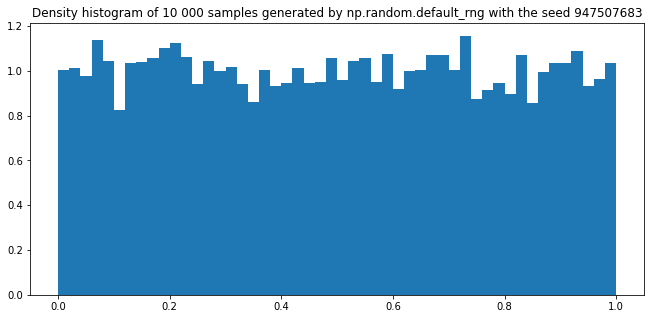

In [14]:
plt.figure(figsize=(11,5))
plt.title(f"Density histogram of 10 000 samples generated by np.random.default_rng with the seed {seed}")
plt.hist([rng.random() for _ in range(10000)], density=True, bins=50)
plt.show()

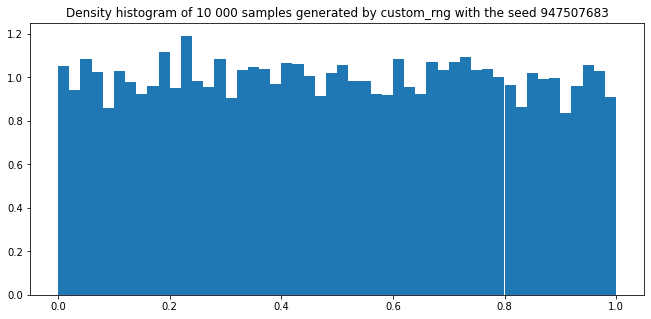

In [13]:
plt.figure(figsize=(11,5))
plt.title(f"Density histogram of 10 000 samples generated by custom_rng with the seed {seed}")
plt.hist([custom_rng.random() for _ in range(10000)], density=True, bins=50)
plt.show()

## Generating/Simulating a random variables

**Theorem** *Let $U$ be a uniform random variable on $]0,1[$ and $X$ a real random variable. Assume that the cumulative distribution function $F_X$ of $X$, $F_X (u) = \mathbb{P} (X \leq u)$, is continuous. Then the random variable $Y$
$$ Y = F_X^{-1}(U) $$ has distribution $F_X$. That is to say, $X$ and $Y$ have the same law.*

An algorithmic consequence of this theorem is that to generate (or simulate) *i.i.d.* samples having the law of a random variable $X$, one can first use a generator of uniform samples in $]0,1[$ and then use the invert distribution function $F_X^{-1}$ to compute *i.i.d.* samples from X.

Of course, such a method assumes that we have a way to compute (or estimate with good enough precision) $F_X^{-1}$.

**Algorithm for generating a sample from random variable X using $F_X^{-1}$**

- `Generate` *u* `uniformly at random on` $]0,1[$
- `Output` $F_x^{-1}(u)$

The function $F_X^{-1}$ of a unitary centered random variable, $X \sim \mathcal{N}(0,1)$, is implemented in the next cell.

In [14]:
# Gaussian distribution
F_gaussian_inv = lambda u : np.sqrt(2)*erfinv(2*u-1)

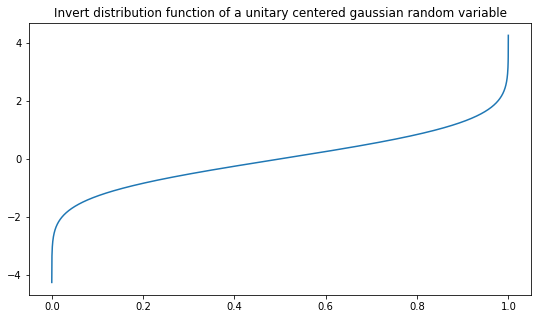

In [15]:
N = 5000
x = np.linspace(0+1e-5, 1-1e-5, N)
y = F_gaussian_inv(x)
plt.figure(figsize=(9,5))
plt.title("Invert distribution function of a unitary centered gaussian random variable")
plt.plot(x,y)
plt.show()

#### Question 6

Using `np.random.default_rng`, generate a sequence of 10 000 samples according to a unitary centered gaussian distribution and plot a histogram. Modify the `LC_RNG` to do the same with your custom rng.

#### Answer 6

##### Simulation using `numpy` random number generator

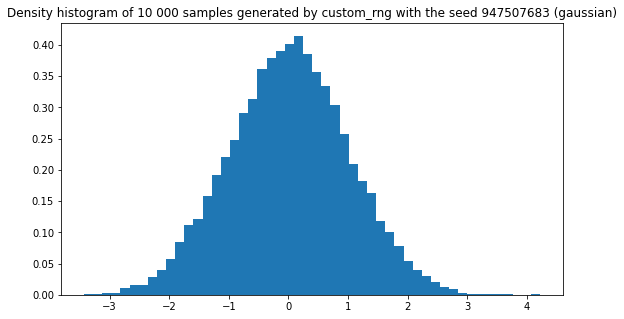

In [16]:
plt.figure(figsize=(9,5))
plt.title(f"Density histogram of 10 000 samples generated by custom_rng with the seed {seed} (gaussian)")
plt.hist(rng.normal(size=10000), density=True, bins=50)
plt.show()

##### Simulation using `custom` random number generator

In [17]:
class LC_RNG:
    def __init__(self, seed):
        self.seed = seed
        self.ctr = seed
        
        self.m = 1103515245 
        self.c = 12345
        self.max_int = 2**31
    
    def __str__(self):
        return "Generator (LCG customed)"
    
    def generate_int(self):
        self.ctr = ( self.m * self.ctr + self.c ) % self.max_int
        return self.ctr
        
    def _random(self):
        pseudo_random_int = self.generate_int()
        if pseudo_random_int == 0:
            pseudo_random_int = self.generate_int()
        return pseudo_random_int / self.max_int
    
    def random(self, nbr_samples=None):
        if nbr_samples is None:
            samples = self._random()
        else:
            samples = []
            for _ in range(nbr_samples):
                samples.append(self._random())
        return samples
    
    def _normal(self):
        pseudo_random_float = self.random()
        return np.sqrt(2)*erfinv(2*pseudo_random_float-1)
    
    def normal(self, nbr_samples=None):
        if nbr_samples is None:
            samples = self._normal()
        else:
            samples = []
            for _ in range(nbr_samples):
                samples.append(self._normal())
        return samples
    
custom_rng = LC_RNG(seed)

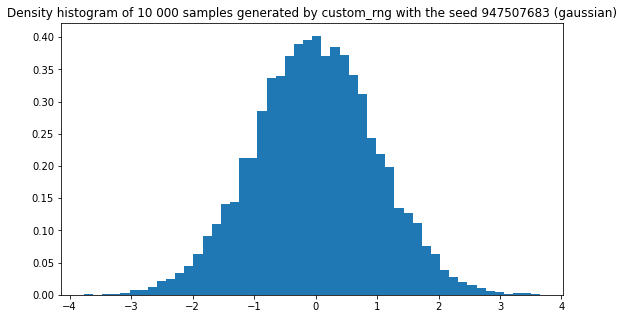

In [18]:
plt.figure(figsize=(9,5))
plt.title(f"Density histogram of 10 000 samples generated by custom_rng with the seed {seed} (gaussian)")
plt.hist(custom_rng.normal(10000), density=True, bins=50)
plt.show()

#### Question 7

What could have gone wrong? Implement a `Dummy_LC_RNG` class with $c=1$ and $m=128$. Re-do the previous experiments and try changing `m` from *128* to *127* and see what happens.

#### Answer 7

In [19]:
class Dummy_LC_RNG:
    def __init__(self, seed, m=128):
        self.seed = seed
        self.ctr = seed
        
        self.m = m
        self.c = 1
        self.max_int = 2**31
    
    def __str__(self):
        return "Dummy Generator (LCG customed)"
    
    def generate_int(self):
        self.ctr = ( self.m * self.ctr + self.c ) % self.max_int
        return self.ctr
        
    def random(self):
        pseudo_random_int = self.generate_int()
        if pseudo_random_int == 0:
            pseudo_random_int = self.generate_int()
        return pseudo_random_int / self.max_int

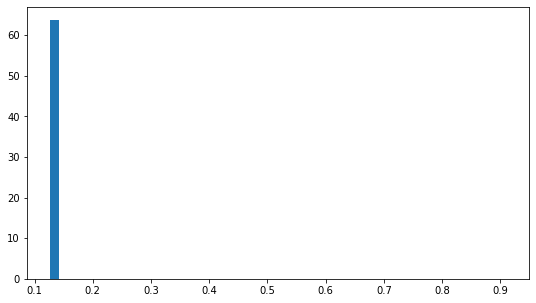

In [20]:
dummy_rng = Dummy_LC_RNG(seed)
plt.figure(figsize=(9,5))
plt.hist([dummy_rng.random() for _ in range(10000)], density=True, bins=50)
plt.show()

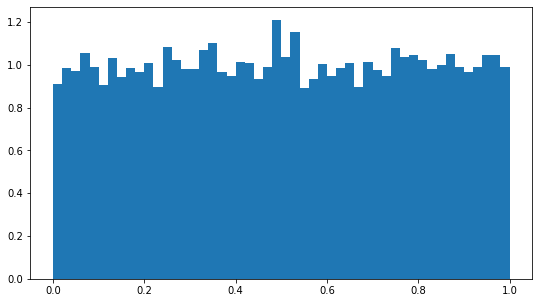

In [21]:
dummy_rng = Dummy_LC_RNG(seed, 127)
plt.figure(figsize=(9,5))
plt.hist([dummy_rng.random() for _ in range(10000)], density=True, bins=50)
plt.show()

As it can be seen, one must be careful when crafting a pseudo random number generator. Furthermore, one should also be careful that $x_{n+1}$ and $x_n$ are *as independent as possible*. Although this may seem counter-intuitive to do so with a completely deterministic procedure, there are ways to measure the statistical correlation of samples.

An analogy is the one of [shuffling a deck of cards](https://chance.dartmouth.edu/teaching_aids/books_articles/Mann.pdf). While shuffling is a completely deterministic procedure we have a feeling that after shuffling, if done correctly, we get a random permutation of the cards that is roughly independent from the original permutation of the deck before shuffling.

# Part 2 - Hands on Statistics

In this part, we show how to compute the **expected value** of a random sequence/random variable. We do so because this is mainly the only statistical quantity you will have to compute in the following practical sessions.

There are two main ways to compute the **mean** of a sequence of numbers, an *offline* and an *online* way. Given a sequence $(x_i)_{i \in \{1, \cdots , n \}}$ of real numbers, we can compute the mean $\bar x_n$ by first computing the sum of all the elements, $\sum_i x_i$ and then dividing by the number of elements. This is the offline method. If we were given a new number $x_{n+1}$ we would have to re-do all the additions and division. Mathematically, the formula is:
$$ \bar x_n = \frac{1}{n} \sum_{i=1}^n x_i  .$$

The online way computes a *sequence of means*, $(\bar x_k)_{k \in \{1, \cdots , n \} }$, where $\bar x_k$ is the mean of the subsequence (or slice) $(x_i)_{i \in \{1, \cdots , k \}}$. The last element of the sequence of means is the mean of the original sequence. Mathematically, we initiate the sequence with $\bar x_1 = x_1$ and the update rule is:

$$ \bar x_{k+1} = \frac{1}{k+1}(k \bar x_k + x_{k+1}) . $$

The advantage of the online method is that we don't need to store the sequence of all samples and that we can immediatly update the mean once given a new sample.

#### Question 8

Check that the online methods indeed is correct.

#### Question 9

Write as many functions as you can to compute the mean of a `python list` and check on a random sequence if they give the same result. What can you say?

#### Answer 9

In [22]:
def mean_1(l):
    agg = 0
    i = 0
    for elm in l:
        agg += elm
        i += 1
    return agg / i

def mean_2(l):
    m = 0
    i = 0
    for elm in l:
        m = (i*m + elm)/(i+1)
        i += 1
    return m

def mean_3(l):
    m = np.sum(l) / len(l)
    return m

def mean_4(l):
    m = sum(l) / len(l)
    return m

def mean_5(l):
    m = math.fsum(l) / len(l)
    return m

def update_mean(m, n, elm):
    assert n >= 0
    return (n*m + elm)/(n+1)

In [23]:
samples = rng.random(1000)
print(f"mean_1(samples)  = {mean_1(samples)}\n\
mean_2(samples)  = {mean_2(samples)}\n\
mean_3(samples)  = {mean_3(samples)} (same result than np.mean)\n\
mean_4(samples)  = {mean_4(samples)}\n\
mean_5(samples)  = {mean_5(samples)}\n\
np.mean(samples) = {np.mean(samples)} (float64)\n\
np.mean(samples) = {np.mean(samples, dtype='float32')} (float32)\n\
np.mean(samples) = {np.mean(samples, dtype='float16')}  (float16)\n")

mean_1(samples)  = 0.5103409440103216
mean_2(samples)  = 0.5103409440103205
mean_3(samples)  = 0.5103409440103216 (same result than np.mean)
mean_4(samples)  = 0.5103409440103216
mean_5(samples)  = 0.5103409440103216
np.mean(samples) = 0.5103409440103216 (float64)
np.mean(samples) = 0.5103409290313721 (float32)
np.mean(samples) = 0.51025390625  (float16)



In [24]:
def sum_1(l):
    agg = 0
    for elm in l:
        agg += elm
    return agg

def sum_3(l):
    m = np.sum(l)
    return m

def sum_4(l):
    m = sum(l)
    return m

def sum_5(l):
    m = math.fsum(l)
    return m

In [25]:
print(f"sum_1(samples)  = {sum_1(samples)}\n\
sum_3(samples)  = {sum_3(samples)} (same result than np.mean)\n\
sum_4(samples)  = {sum_4(samples)}\n\
sum_5(samples)  = {sum_5(samples)}\n\
np.sum(samples) = {np.sum(samples)} (float64)\n\
np.sum(samples) = {np.sum(samples, dtype='float32')} (float32)\n\
np.sum(samples) = {np.sum(samples, dtype='float16')}  (float16)\n")

sum_1(samples)  = 510.34094401032155
sum_3(samples)  = 510.34094401032155 (same result than np.mean)
sum_4(samples)  = 510.34094401032155
sum_5(samples)  = 510.3409440103216
np.sum(samples) = 510.34094401032155 (float64)
np.sum(samples) = 510.3409423828125 (float32)
np.sum(samples) = 510.25  (float16)



#### Question 10

Let $(X_i)_{i \in \{1, \cdots , n\}}$ be $n$ *i.i.d* random variables such that $X_i \sim X$ with $\mathbb{E}(X) = \mu$.

The **Law of large numbers** states that the empirical mean of those $n$ *i.i.d.* random variables,
$$ \frac{X_1 + X_2 + \cdots + X_{n-1} + X_n}{n} ,$$
converges (in some sense) to $\mu$ as $n$ tends to infinity.

Write an experiment that collects 10 000 samples from a unitary centered gaussian distribution, and computes the sequence of updated means. Plot the histogram of samples (as above) and the function $k \mapsto \bar x_k$.

#### Answer 10

In [26]:
class experiment:
    def __init__(self, nbr_samples=0, mean=0):
        assert nbr_samples >= 0
        self.nbr_samples = nbr_samples
        self.mean = mean
        
        # We store information, only for the plots
        self.samples = []
        self.means = []
    
    def update_mean(self, elm):
        self.mean = (self.nbr_samples * self.mean + elm) / (self.nbr_samples+1)
        self.nbr_samples += 1
        
        # Storage for the plots
        self.means.append(self.mean)
        self.samples.append(elm)

In [27]:
xp = experiment()

In [28]:
nbr_experiments = 1000
for _ in range(nbr_experiments):
    sample = rng.normal()
    xp.update_mean(sample)

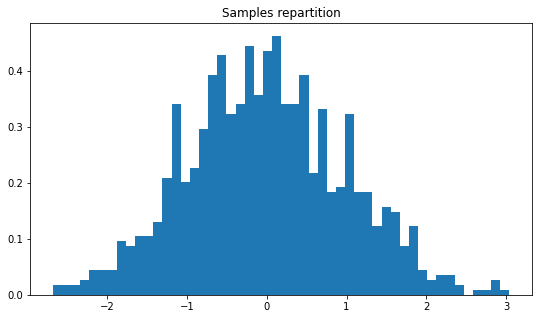

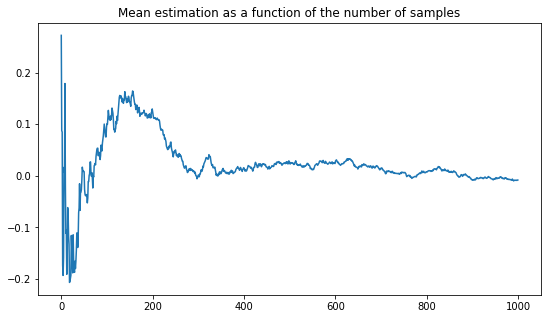

In [29]:
plt.figure(figsize=(9,5))
plt.title("Samples repartition")
plt.hist(xp.samples, density=True, bins=50)
plt.show()

plt.figure(figsize=(9,5))
plt.title("Mean estimation as a function of the number of samples")
plt.plot(xp.means)
plt.show()

#### Question 11

Repeat the experiments of the previous question 10 times and plot the 10 trajectories $k \mapsto \bar x_k$. Add the curves $k \mapsto \pm \frac{1}{\sqrt{k}}$ to your plot. Comment if you remember the central limit theorem, otherwise, come back with the next question in hindsight.

#### Answer 11

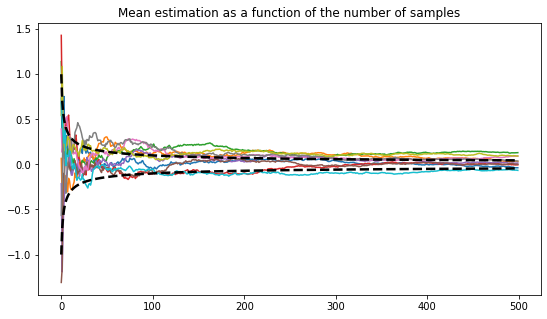

In [30]:
nbr_experiments = 10
nbr_samples = 500
plt.figure(figsize=(9,5))
plt.title("Mean estimation as a function of the number of samples")
for _ in range(nbr_experiments):
    xp = experiment()
    for _ in range(nbr_samples):
        sample = rng.normal()
        xp.update_mean(sample)
    plt.plot(xp.means)

plt.plot([1/np.sqrt(n) for n in range(1, 501)], linewidth=2.5, c='black', linestyle='--')
plt.plot([-1/np.sqrt(n) for n in range(1, 501)], linewidth=2.5, c='black', linestyle='--')

plt.show()

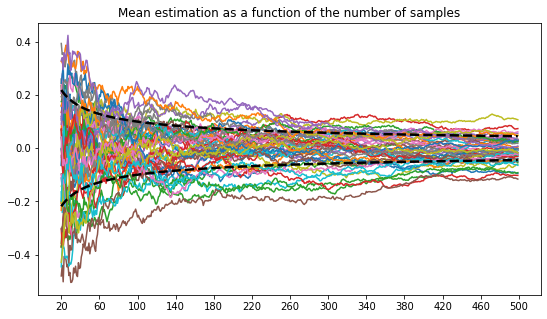

In [31]:
nbr_experiments = 50
nbr_samples = 500
plt.figure(figsize=(9,5))
plt.xticks([n for n in range(20, 501,40)])
plt.title("Mean estimation as a function of the number of samples")
for _ in range(nbr_experiments):
    xp = experiment()
    for _ in range(nbr_samples):
        sample = rng.normal()
        xp.update_mean(sample)
    plt.plot([n for n in range(20, 500)], xp.means[20:])
plt.plot([n for n in range(20, 500)], [1/np.sqrt(n) for n in range(21, 501)], linewidth=2.5, c='black', linestyle='--')
plt.plot([n for n in range(20, 500)],[-1/np.sqrt(n) for n in range(21, 501)], linewidth=2.5, c='black', linestyle='--')

plt.show()

#### Question 12

Let $(X_i)_{i \in \{1, \cdots , n\}}$ be $n$ *i.i.d* random variables such that $X_i \sim X$ with $\mathbb{E}(X) = \mu$ and $\mathbb{V}(X) = \sigma^2$.
The **Central Limit Theorem** states that the empirical mean of those $n$ *i.i.d.* random variables,
$$ \frac{X_1 + X_2 + \cdots + X_{n-1} + X_n}{n} ,$$
has the law of a Gaussian random variable, $\mathcal{N} (\mu, \frac{\sigma}{\sqrt{n}})$ in the limit of large $n$.

Let X be a random variable having the  uniform law on $]0,1[$. Craft an experiment to visualize the central limit theorem when samples are drawn from $X$.

#### Answer 12

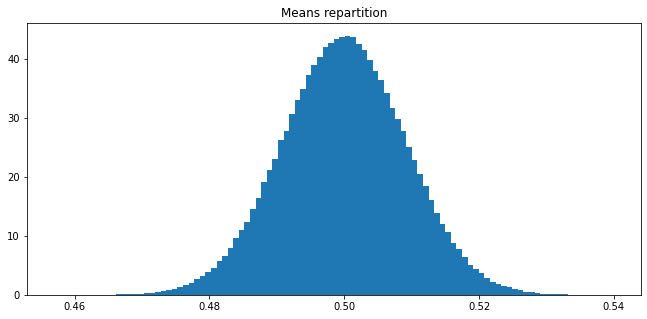

In [32]:
nbr_list = 300000
means = []
for _ in range(nbr_list):
    l = rng.random(1000)
    means.append(mean_1(l))

plt.figure(figsize=(11,5))
plt.title("Means repartition")
plt.hist(means, density=True, bins=100)
plt.show()

## Standard deviation and Quantiles

Given a list of samples drawn from a random variable $X$, what relevant quantities could be computed? In the previous subsection, we emphasize the **empirical mean** and illustrate how it is related to the **true mean** $\mathbb{E}(X)$. Given the empirical mean, it is natural to measure the spread of the samples around that value. In other words, we want to compute an empirical version of the **standard deviation**.

There are two main ways of computing the empirical standard deviation. One that is called the **uncorrected standard deviation**,
$$ \hat \sigma_u = \sqrt{\frac{1}{n} \sum_{i=1}^n (x_i - \hat \mu)^2} $$
and the other that is called the **corrected standard deviation**
$$ \hat \sigma_c = \sqrt{\frac{1}{n-1} \sum_{i=1}^n (x_i - \hat \mu)^2} $$

*Remark*: `np.std` computes the uncorrected standard deviation.

Intuitively, it corresponds to two viewpoints on how to handle small sample size. When $n=1$, $\hat \sigma_u = 0$ while $\hat \sigma_c = \infty $ (or is not defined). Indeed, when $n=1$, one could think one of the two things
- The empirical standard deviation is 0 since there is no deviation in the dataset
- The empirical standard deviation is undefined since there is no way to empirically compute a deviation in the dataset

On the other hand, $\hat \sigma_u \rightarrow \sigma$, and $\hat \sigma_u \rightarrow \sigma$, meaning that both estimators have the same asymptotic behaviors (large sample size). In particular,
$$ \frac{\hat \sigma_c}{\hat \sigma_u} =\sqrt{\frac{n}{n-1}} \rightarrow 1 $$

Mathematically, $\hat \sigma_u$ is a biased estimator ($\mathbb{E}(\hat \sigma_u) \neq \sigma$) and $\hat \sigma_c$ is an unbiased estimator ($\mathbb{E}(\hat \sigma_c) = \sigma$).

#### Question 13 
Implement functions computing the two empirical standard deviation. Check that both converges to $\sigma$ as the number of samples increases.

#### Answer 13

In [33]:
samples = custom_rng.normal(500000)

def standard_deviation_uncorrected(samples):
    mu = mean_1(samples)
    std = sum((samples - mu)**2) / len(samples)
    return np.sqrt(std)

def standard_deviation_corrected(samples):
    assert len(samples) > 1, "The length of the samples array should be strictly larger than 1"
    mu = mean_1(samples)
    std = sum((samples - mu)**2) / (len(samples) -1)
    return np.sqrt(std)

In [34]:
print(standard_deviation_uncorrected(samples))
print(standard_deviation_corrected(samples))

1.0006729694819605
1.000673970156431


Another natural way to compute the spread of a list of samples is *via* a function. This function associates to each interval $[\mu - x, \mu + x]$, $x>0$, the fraction of samples that lies within it. In particular, it is interesting to know the fraction of samples lying in $[\mu - \sigma, \mu + \sigma]$.

For the readers aware of the notion (remind the first part of this practical session), this is highly related to the concept of **cumulative distribution function**.

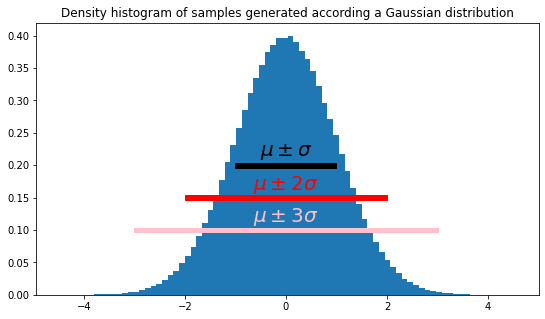

In [35]:
plt.figure(figsize=(9,5))
plt.title(f"Density histogram of samples generated according a Gaussian distribution")
plt.hist(samples, density=True, bins=80)
s = standard_deviation_corrected(samples)
m = mean_1(samples)
plt.arrow(m-s, 0.2, 2*s, 0, head_length=0, head_width=0, width=0.007, shape="full", fc="black", ec="black")
plt.text(m, 0.22, "$\mu\pm\sigma$", ha='center', va='center', color="black", size=20)

plt.arrow(m-2*s, 0.15, 4*s, 0, head_length=0, head_width=0, width=0.007, shape="full", fc="red", ec="red")
plt.text(m, 0.17, "$\mu\pm2\sigma$", ha='center', va='center', color="red", size=20)

plt.arrow(m-3*s, 0.1, 6*s, 0, head_length=0, head_width=0, width=0.007, shape="full", fc="pink", ec="pink")
plt.text(m, 0.12, "$\mu\pm3\sigma$", ha='center', va='center', color="pink", size=20)
plt.show()

#### Question 14 
What percentage of samples fall in the interval $[\mu - \sigma, \mu+\sigma]$? and $[\hat\mu - \hat\sigma, \hat\mu+\hat\sigma]$? Check the [68-95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

#### Answer 14 

In [36]:
def percent(samples, sigma=1, mu=0):
    ctr = 0
    for sample in samples:
        if sample >= mu - sigma and sample <= mu + sigma:
            ctr += 1
    return ctr / len(samples)

In [37]:
percent(samples, 1)*100

68.228

In [38]:
percent(samples, 2)*100

95.4074

In [39]:
percent(samples, 3)*100

99.7274

#### Question 15 
Implement a function that computes the  $\alpha$ quantile of a list of samples, that is to say, an empirical value $\hat x_\alpha$ that corresponds to the true value $x_\alpha$, defined as 
$$ x_\alpha = \sup_x \{ x \: | \: \mathbb{P}(X \leq x) \leq \alpha \} $$
Using this function, how can you compute the **median**? How is the median different from the mean?

#### Answer 15

In [40]:
def quantile(samples, alpha):
    sorted_samples = np.sort(samples)
    k = np.floor(alpha*len(samples))
    return samples[k]

# Part 3 - Markov Reward Process

In the following, we consider sequences of random variables that are not necessarily *i.i.d.*. That is, we want to study sequences represented as
$$x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \cdots \rightarrow x_n .$$

In the following, we shall assume that the generative process is Markovian, *i.e.*, the future is independent from the past given the present. The sequence may therefore be represented as

$$x_0 \overset{p(x_1 | x_0)}{\longrightarrow} x_1 \overset{p(x_2 | x_1)}{\longrightarrow} x_2 \overset{p(x_3 | x_2)}{\longrightarrow} \cdots \overset{p(x_n | x_{n-1})}{\longrightarrow} x_n , $$

where $p$ is called the **probability transition function**. In the following, this function is independent of $n$ (time homogeneity property). Therefore, the model may be represented more concisely: $$ x_{k-1} \overset{p(x_k | x_{k-1})}{\longrightarrow} x_k .$$

#### Question 16

Consider the Markov chain $$x_0 \overset{p(x_1 | x_0)}{\longrightarrow} x_1 \overset{p(x_2 | x_1)}{\longrightarrow} x_2 \overset{p(x_3 | x_2)}{\longrightarrow} \cdots \overset{p(x_n | x_{n-1})}{\longrightarrow} x_n $$
where $x_0 = 0$ and 
$$
\left\{
\begin{array}{lcr}
    p (x_k = x_{k-1} + 1 | x_{k-1 }) & =  & 0.5 \\
    p (x_k = x_{k-1} - 1 | x_{k-1 }) & = & 0.5 \\
\end{array}
\right.
$$

Write a fonction that generate a sequence of $n$ samples according to this process. Plot such a trajectory. Zoom-in. What can you say?

#### Answer 16

In [41]:
def random_walk(horizon):
    start = 0
    values = [0]
    for _ in range(horizon):
        x = rng.random()
        if x < 0.5:
            values.append(values[-1] + 1)
        else:
            values.append(values[-1] - 1)
    return values

In [42]:
H = 10000
rw = random_walk(H)

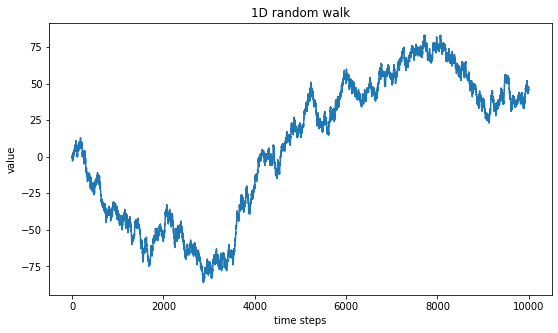

In [43]:
plt.figure(figsize=(9,5))
plt.title("1D random walk")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(rw)
plt.show()

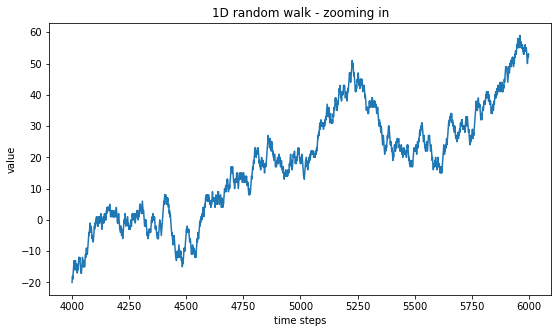

In [44]:
plt.figure(figsize=(9,5))
plt.title("1D random walk - zooming in")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(range(4000,6000),rw[4000:6000])
plt.show()

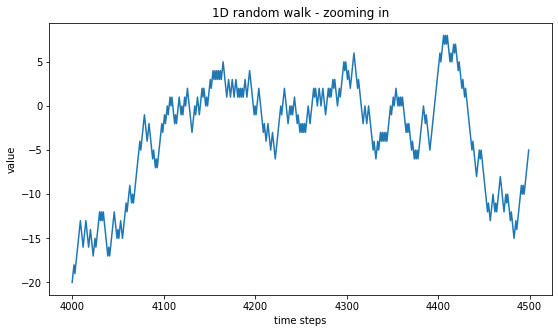

In [45]:
plt.figure(figsize=(9,5))
plt.title("1D random walk - zooming in")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(range(4000,4500),rw[4000:4500])
plt.show()

### Discretized Brownian motion

#### Question 17

Answer the same question than the previous one but with a process such that $X_{n+1}|X_n \sim \mathcal{N}(0, \epsilon)$.

#### Answer 17

In [46]:
def brownian_motion(horizon, epsilon=0.1):
    start = 0
    values = [0]
    for _ in range(horizon):
        x = rng.normal()
        values.append(values[-1] + epsilon*x)
    return values

In [47]:
H = 10000
bm = brownian_motion(H)

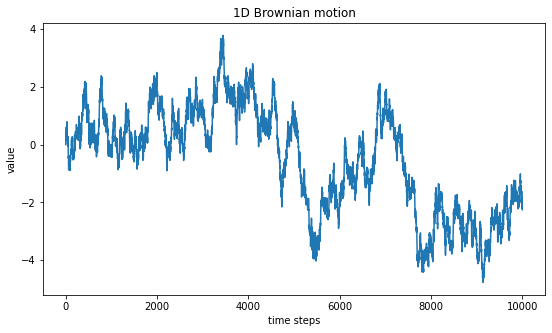

In [48]:
plt.figure(figsize=(9,5))
plt.title("1D Brownian motion")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(bm)
plt.show()

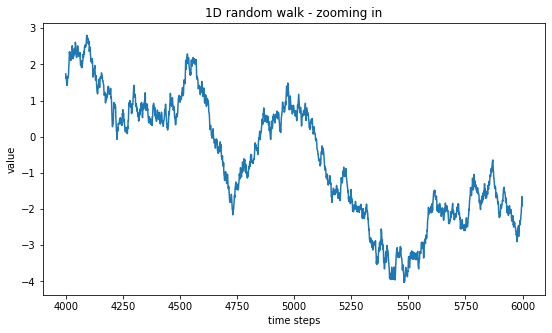

In [49]:
plt.figure(figsize=(9,5))
plt.title("1D random walk - zooming in")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(range(4000,6000),bm[4000:6000])
plt.show()

#### Question 18

Write a function that computes and plots a Brownian motion in 2D.

#### Answer 18

In [50]:
def brownian_motion2d(horizon, epsilon=0.1):
    start = 0
    X = [0]
    Y = [0]
    for _ in range(horizon):
        x = rng.normal()
        y = rng.normal()
        X.append(X[-1] + epsilon*x)
        Y.append(Y[-1] + epsilon*y)
    return X,Y

In [51]:
H = 10000
X, Y = brownian_motion2d(H)

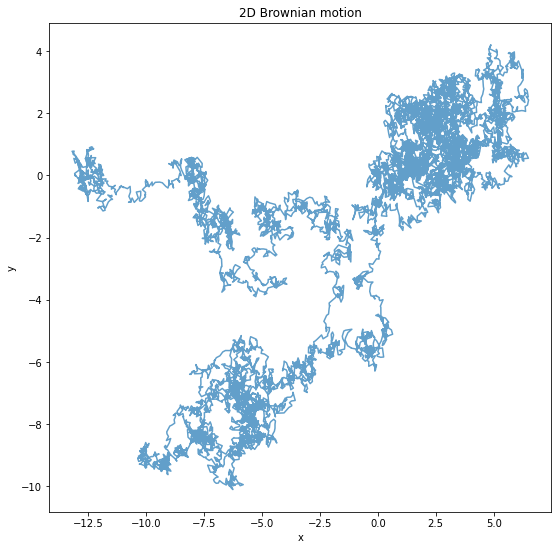

In [52]:
plt.figure(figsize=(9,9))
plt.title("2D Brownian motion")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(X, Y, alpha=0.7)
plt.show()

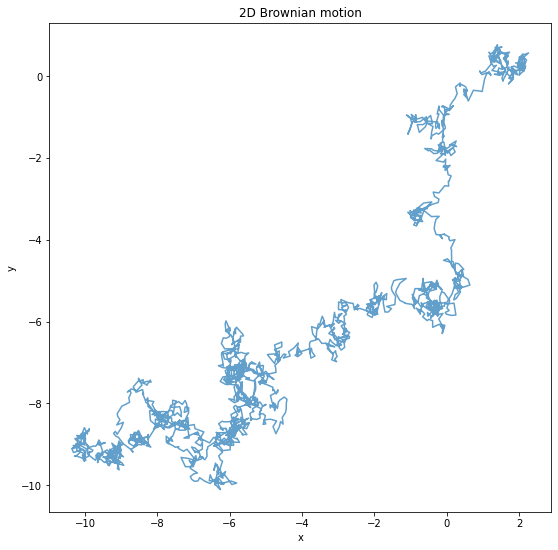

In [53]:
plt.figure(figsize=(9,9))
plt.title("2D Brownian motion")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(X[5000:7000], Y[5000:7000], alpha=0.7)
plt.show()

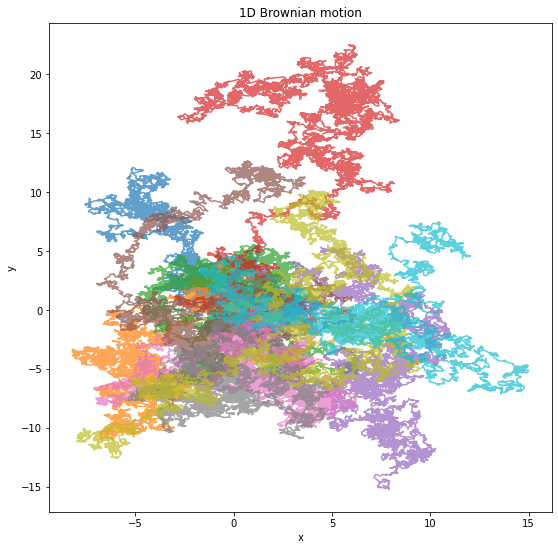

In [54]:
plt.figure(figsize=(9,9))
plt.title("1D Brownian motion")
plt.xlabel("x")
plt.ylabel("y")
for _ in range(10):
    X, Y = brownian_motion2d(H)
    plt.plot(X, Y, alpha=0.7)
plt.show()

## Random walk on a graph

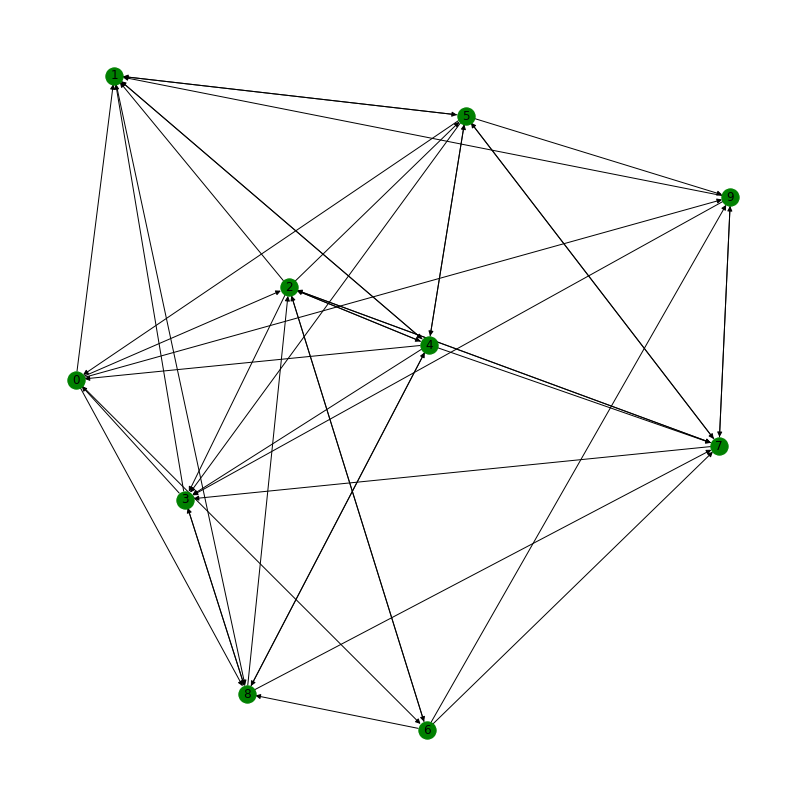

In [55]:
plt.figure(figsize=(11,11))
Graph = nx.gnp_random_graph(10, 0.5, directed=True)
nx.draw(Graph, with_labels=True, node_color='green')
plt.show()

In [56]:
for (u,v,w) in Graph.edges(data=True):
    w['weight'] = rng.random()
    w['reward'] = rng.normal() + 2

#### Question 19

Given a labeled directed graph $G = (V, E, w, r, v_0)$ where $V$ is the set of vertices, $E$ the set of edges, $w: E \rightarrow ]0,1[$ and $r: E \rightarrow \mathbb{R}$ and $v_0 \in V$ we can compute a Markovian random walk on the vertices of G by considering that $$ p (v_i | v_{i-1}) = \frac{w(v_{i-1}, v_i)}{\sum_v w(v_{i-1}, v)} .$$

The specificity of this random walk is that at each transition $ v_{i-1} \rightarrow v_i$, we collect a reward $r(v_{i-1}, v_i)$.

Write a function that generates a random walk along a graph, collects the history of vertices (*i.e.* samples) and collects the history of rewards. Plot the updated mean reward (it should be around 2, but why?).

#### Answer 19

In [57]:
def random_walk_graph(G, horizon=1000, starting_node=0):
    samples = []
    nodes = [starting_node]
    for _ in range(horizon):
        adj_data = G.adj[nodes[-1]]
        neighbors = []
        weights = []
        for n in adj_data:
            neighbors.append(n)
            weights.append(adj_data[n]['weight'])
        w = sum(weights)
        proba = [h/w for h in weights]
        next_node = np.random.choice(neighbors, p=proba)
        nodes.append(next_node)
        samples.append(adj_data[next_node]['reward'])
    return nodes, samples

In [58]:
nodes, rewards = random_walk_graph(Graph)
mean_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)

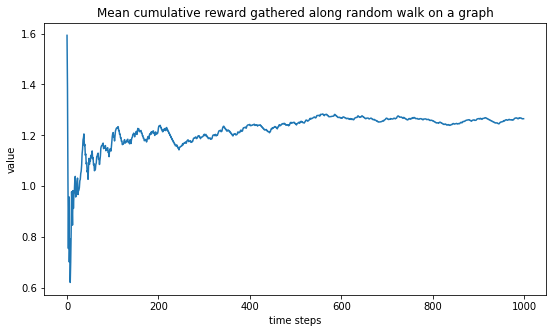

In [59]:
plt.figure(figsize=(9,5))
plt.title("Mean cumulative reward gathered along random walk on a graph")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(mean_reward)
plt.show()

In [60]:
nodes, rewards = random_walk_graph(Graph, horizon=100)
mean_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)

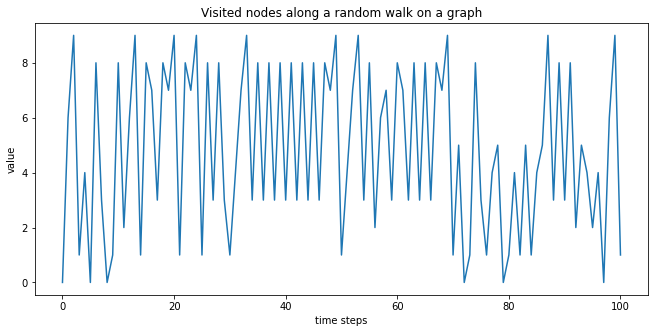

In [61]:
plt.figure(figsize=(11,5))
plt.title("Visited nodes along a random walk on a graph")
plt.xlabel("time steps")
plt.ylabel("value")
plt.plot(nodes)
plt.show()

#### Do your own experiments.

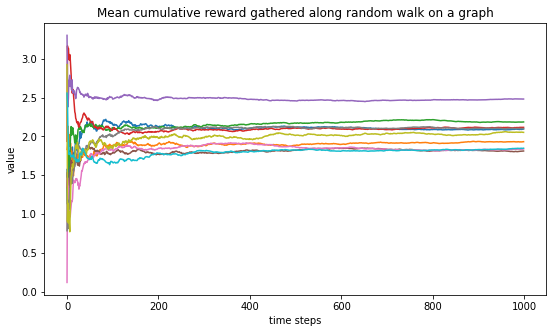

In [62]:
plt.figure(figsize=(9,5))
plt.title("Mean cumulative reward gathered along random walk on a graph")
plt.xlabel("time steps")
plt.ylabel("value")
for _ in range(10):
    for (u,v,w) in Graph.edges(data=True):
        w['weight'] = rng.random()
        w['reward'] = rng.normal() + 2
    nodes, rewards = random_walk_graph(Graph)
    mean_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)
    plt.plot(mean_reward)
plt.show()

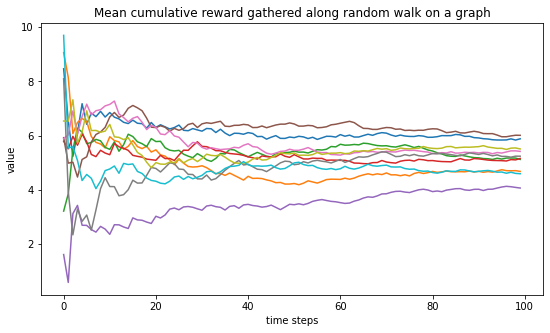

In [63]:
plt.figure(figsize=(9,5))
plt.title("Mean cumulative reward gathered along random walk on a graph")
plt.xlabel("time steps")
plt.ylabel("value")
for _ in range(10):
    for (u,v,w) in Graph.edges(data=True):
        w['weight'] = rng.random()
        w['reward'] = rng.normal() + 10*rng.random()
    nodes, rewards = random_walk_graph(Graph, horizon=100)
    mean_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)
    plt.plot(mean_reward)
plt.show()

# Bonus fractal!

In [64]:
import matplotlib.cm as cm

In [65]:
im_width, im_height = 1280, 1280
c = complex(-0.1, 0.65)
zabs_max = 10
nbr_it_max = 1000
xmin, xmax = -1.5, 1.5
xwidth = xmax - xmin
ymin, ymax = -1.5, 1.5
yheight = ymax - ymin

julia = np.zeros((im_width, im_height))

for x in range(im_width):
    for y in range(im_height):
        ctr = 0
        
        z = complex(x / im_width * xwidth + xmin,
                    y / im_height * yheight + ymin)

        while abs(z) <= zabs_max and ctr < nbr_it_max:
            z = z**2 + c
            ctr += 1

        julia[x,y] = ctr / nbr_it_max

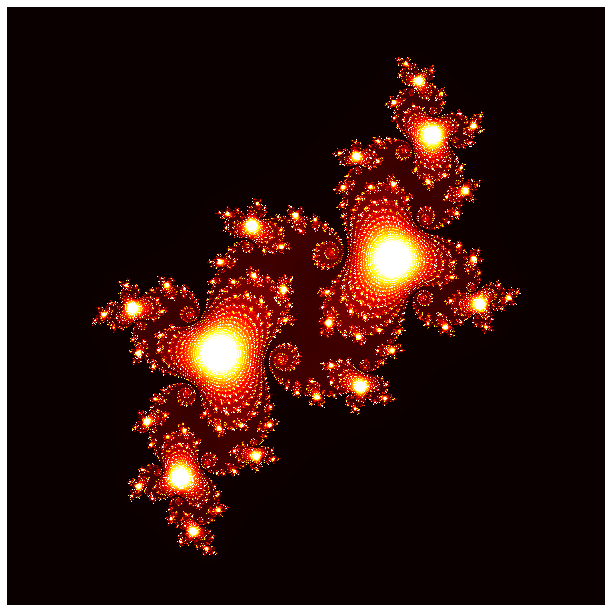

In [66]:
plt.figure(figsize=(15,11))
plt.imshow(julia, interpolation='nearest', cmap=cm.hot)
plt.axis('off')
plt.show()